In [1]:
#Histopathological Cancer Detection Project

# CNN Model 5: Transfer learning (EfficientNet), Data augmentation, and <50% sample of Data

## Import packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, datasets

2025-07-29 00:03:06.834984: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753747387.102265      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753747387.191606      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## View Data, Distributions, and Images with labels

In [3]:
train = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

In [4]:
train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [5]:
train.isnull().sum().T

id       0
label    0
dtype: int64

In [6]:
(train.label.value_counts()/len(train.label)).to_frame().T

label,0,1
count,0.594969,0.405031


In [7]:
train['filenames'] = train['id']+'.tif'

In [8]:
train.head()

,id,label,filenames
0,f38a6374c348f90b587e046aac6079959adf3835,0,f38a6374c348f90b587e046aac6079959adf3835.tif
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif
2,755db6279dae599ebb4d39a9123cce439965282d,0,755db6279dae599ebb4d39a9123cce439965282d.tif
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif
4,068aba587a4950175d04c680d38943fd488d6a9d,0,068aba587a4950175d04c680d38943fd488d6a9d.tif


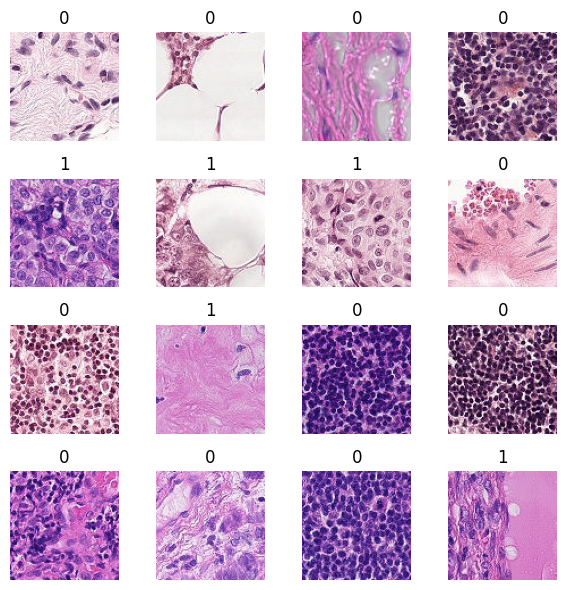

In [9]:
train_images_path = '/kaggle/input/histopathologic-cancer-detection/train'
sample = train.sample(n=16).reset_index()

plt.figure(figsize = (6,6))

for i in range(len(sample)):
    img = mpimg.imread(f'{train_images_path}/{sample.filenames[i]}')
    #label = sample.label
    plt.subplot(4,4,i+1)
    plt.imshow(img)
    plt.title(sample.label[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

## Sample the Data to make training more efficient

In [10]:
SS = 50000
RS = 10

positives = train[train['label']==1].sample(SS, random_state = RS)
negatives = train[train['label']==0].sample(SS, random_state = SS)

new_train = pd.concat([positives,negatives], axis = 0).reset_index(drop = True)
new_train = shuffle(new_train)

In [11]:
new_train.head()

,id,label,filenames
6594,01fd9fd547193a05510d68985d68fa62bb60d7f2,1,01fd9fd547193a05510d68985d68fa62bb60d7f2.tif
17444,6db96da77b2235fd602a9355e185438e765443ff,1,6db96da77b2235fd602a9355e185438e765443ff.tif
67177,b5076cd78398c7a5e9ee58154b55320737fe7f46,0,b5076cd78398c7a5e9ee58154b55320737fe7f46.tif
16085,fccc9dd4181e79aeebe55de5948147e080096215,1,fccc9dd4181e79aeebe55de5948147e080096215.tif
94959,f2609ca8ec856375d5f7d14d62b4b0b9750140eb,0,f2609ca8ec856375d5f7d14d62b4b0b9750140eb.tif


In [12]:
(new_train.label.value_counts()/len(new_train)).to_frame().T

label,1,0
count,0.5,0.5


## Train_Test_Split

In [13]:
train_df, val_df = train_test_split(new_train, test_size = .2, random_state = 10, stratify = new_train.label)

print(train_df.shape)
print(val_df.shape)

(80000, 3)
(20000, 3)


## Rescale Images with ImageDataGenerator

In [14]:
train_datagen = ImageDataGenerator(rescale = 1/255)
val_datagen = ImageDataGenerator(rescale = 1/255)

### Make labels into strings

In [15]:
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)

## Create loaders using data augmentation
* reduced batch size to see if it improves the models
* horizontal and vertical flips
* rotation
* height and width shifts
* Images sized 260x260 for the efficientnet model used

In [16]:
%%time
batch_size = 32

train_loader = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = train_images_path,
    x_col = 'filenames',
    y_col = 'label',
    batch_size = batch_size,
    seed = 10,
    shuffle = True,
    class_mode = 'binary',
    horizontal_flip = True,
    vertical_flip = True,
    height_shift_range = .12,
    width_shift_range = .12,
    rotation_range = 18,
    target_size = (260,260)
)

val_loader = val_datagen.flow_from_dataframe(
    dataframe = val_df,
    directory = train_images_path,
    x_col = 'filenames',
    y_col = 'label',
    batch_size = batch_size,
    seed = 10,
    shuffle = True,
    class_mode = 'binary',
    target_size = (260,260)
)

Found 80000 validated image filenames belonging to 2 classes.
Found 20000 validated image filenames belonging to 2 classes.
CPU times: user 1.66 s, sys: 3.18 s, total: 4.83 s
Wall time: 6min 25s


In [17]:
TR_STEPS = len(train_loader)
VAL_STEPS = len(val_loader)

print(TR_STEPS)
print(VAL_STEPS)

2500
625


## Create a model using the EfficientNetV2B2 model from keras as the foundation
* Print the Architecture of the model
* very little learning rate will be used to make sure the model doesn't over fit
* More epochs will be used becasue of the efficiency of training compared to the other models
* Input shape will be increased to 260x260 since that it what EfficientNetV2B2 uses
* Training only the last 30 layers of the model
* Switched to the Swich activation instead of the relu for the dense layers

In [18]:
from tensorflow.keras.activations import swish
from tensorflow import keras

base_model_2=keras.applications.EfficientNetV2B2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(260,260,3),
    pooling=None,
    classes=2,
    classifier_activation="Swish",
)
base_model_2.trainable = True

for layer in base_model_2.layers[:-30]:
    layer.trainable = True



cnn_model_5 = models.Sequential([
    base_model_2,
    layers.GlobalAveragePooling2D(),


    Dense(512, activation = 'swish'),
    Dropout(.4),
    Dense(256, activation = 'swish'),
    Dropout(.3),
    Dense(128, activation = 'swish'),
    Dropout(.2),
    Dense(1, activation = 'sigmoid')
])
cnn_model_5.summary()

I0000 00:00:1753747788.955049      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b2 (Functional)  │ (None, 9, 9, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       721,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,655,135 (36.83 MB)

 Trainable params: 9,572,847 (36.52 MB)

 Non-trainable params: 82,288 (321.44 KB)

In [19]:
opt = tf.keras.optimizers.Adam(learning_rate = 1e-5)
cnn_model_5.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['AUC'])

## Add callbacks for early stopping if the model doesnt improve
## Add reduced learning rate if the learning stalls to see if it helps improve the model

In [20]:
early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_AUC',      
    patience=10,            
    restore_best_weights=True, 
    mode='max',        
    verbose=1               
)

lr_scheduler_callback = keras.callbacks.ReduceLROnPlateau(
    monitor='val_AUC',      
    factor=0.5,             
    patience=5,             
    min_lr=1e-8,            
    mode='max',             
    verbose=1               
)

callbacks_list = [early_stopping_callback, lr_scheduler_callback]

## Run the first training iteration
* add callbacks
* one running of 50 epochs with new learning rate changes

In [21]:
%%time
h1 = cnn_model_5.fit(
    x = train_loader,
    steps_per_epoch = TR_STEPS,
    epochs = 50,
    validation_data = val_loader,
    validation_steps = VAL_STEPS,
    verbose = 1,
    callbacks = callbacks_list
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1753747876.402928      62 service.cc:148] XLA service 0x7b8e34005ef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753747876.404090      62 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753747884.053536      62 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1753747897.266721      62 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753747897.454082      62 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753747897.909538      62 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753747898.1030

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1086s 382ms/step - AUC: 0.8333 - loss: 0.5033 - val_AUC: 0.9426 - val_loss: 0.3079 - learning_rate: 1.0000e-05
Epoch 2/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 445s 178ms/step - AUC: 0.9341 - loss: 0.3273 - val_AUC: 0.9593 - val_loss: 0.2640 - learning_rate: 1.0000e-05
Epoch 3/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 441s 176ms/step - AUC: 0.9502 - loss: 0.2848 - val_AUC: 0.9677 - val_loss: 0.2354 - learning_rate: 1.0000e-05
Epoch 4/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 434s 173ms/step - AUC: 0.9606 - loss: 0.2535 - val_AUC: 0.9726 - val_loss: 0.2170 - learning_rate: 1.0000e-05
Epoch 5/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 435s 174ms/step - AUC: 0.9689 - loss: 0.2250 - val_AUC: 0.9754 - val_loss: 0.2087 - learning_rate: 1.0000e-05
Epoch 6/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 433s 173ms/step - AUC: 0.9738 - loss: 0.2054 - val_AUC: 0.9778 - val_loss: 0.1906 - learning_rate: 1.0000e-05
Epoch 7/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 434s 174ms/step - AUC: 0.9792 - loss: 0.1827 - val_AUC: 

In [22]:
history = h1.history

## Display the model's performance
* slowly but steadily increased in performance for both training and validation data
* Validation plateaus while the training keeps improving showing some overfitting
* Is pretty efficient learning, and does will after just a few epochs

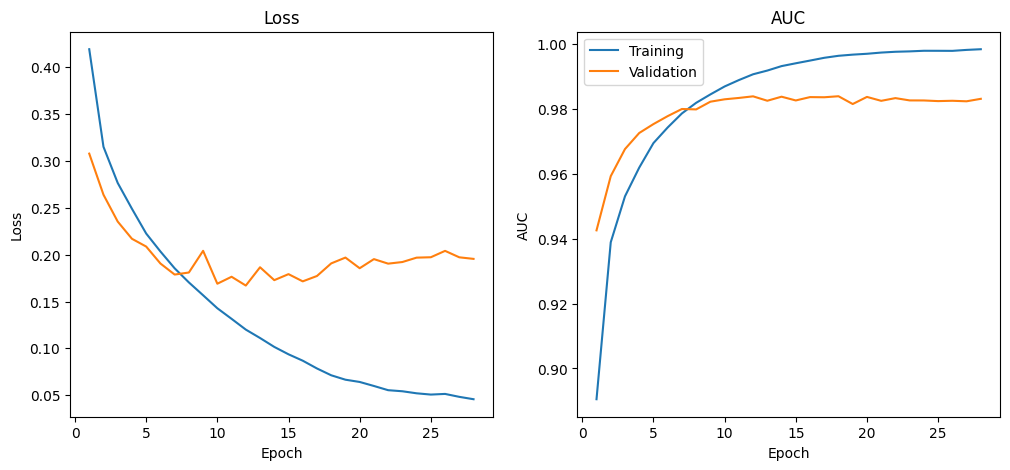

In [23]:
epoch_range = range(1, len(history['loss'])+1)
plt.figure(figsize = [12,5])
plt.subplot(1,2,1)
plt.plot(epoch_range, history['loss'], label = 'Training')
plt.plot(epoch_range, history['val_loss'], label = 'Validation')
plt.xlabel('Epoch');plt.ylabel('Loss');plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(epoch_range, history['AUC'], label = 'Training')
plt.plot(epoch_range, history['val_AUC'], label = 'Validation')
plt.xlabel("Epoch");plt.ylabel("AUC");plt.title("AUC")
plt.legend()
plt.show()

## Save the model

In [24]:
import pickle
cnn_model_5.save('Cancer_Detection_cnn_model_5.h5')
pickle.dump(history, open(f'Cancer_Detection_model_5.pk1', 'wb'))